In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import agama
from astropy.io import fits
from astropy.table import Table
import astropy.coordinates as coord
import astropy.units as u
from matplotlib import patches

In [2]:
plt.rcParams['text.usetex'] = True
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'

agama.setUnits(length=1, velocity=1, mass=1)

figpath = 'figs/'
datapath = 'data/'
simpath = 'sims/'
agama_pot_path = 'agama_potentials/'

In [3]:
'''Import DR3 data'''

hdu = fits.open(datapath+'rvs_data_feh2_parsn3.fits', memmap=True)
t = Table.read(hdu)

In [4]:
'''Transform and cut data'''

coords = coord.SkyCoord(ra=t['RA']*u.deg, dec=t['DEC']*u.deg, distance=t['DIST']*u.kpc, pm_ra_cosdec=t['PMRA']*u.mas/u.yr, pm_dec=t['PMDEC']*u.mas/u.yr, radial_velocity=t['VLOS']*u.km/u.s)

galcen_v_sun = np.array([11.1, 247.4, 7.25])*u.km/u.s#(12.9, 245.6, 7.78)

R_sun = 8.178

coords = coords.transform_to(coord.Galactocentric(galcen_distance=R_sun*u.kpc, galcen_v_sun=galcen_v_sun, z_sun=0*u.pc))

ic = np.array([coords.x.value, coords.y.value, coords.z.value, coords.v_x.value, coords.v_y.value, coords.v_z.value]).T

print(ic.shape)

# Convert to coordinate system where Sun is at x=+8.178kpc, Galactic rotation in +y direction
ic = ic*np.array([-1, 1, 1, -1, 1, 1])

# Perform quality cuts
parsn = t['PARSN']
dist = t['DIST']
MH = t['MH']
logg = t['LOGG']

parsn_min = 10
dist_max = 100

cut = (parsn > parsn_min) * (dist < dist_max)

ic = ic[cut]
MH = MH[cut]
logg = logg[cut]
dist = dist[cut]

(24008015, 6)


In [5]:
'''Remove large variables'''
del hdu, t, coords, parsn, cut

In [6]:
'''Calculate data quantities'''

# bar_angle = 30 * np.pi/180

# phi_data = (np.arctan2(ic[:,1], ic[:,0]) - bar_angle + np.pi) % (2 * np.pi) - np.pi

# plt.hist(phi_data*180/np.pi, bins=100)
# plt.show()
# plt.close()

# r_data = np.linalg.norm(ic[:,0:3], axis=1)
R_data = np.linalg.norm(ic[:,0:2], axis=1)
phi_data_sun = np.arctan2(ic[:,1], ic[:,0])
z_data = ic[:,2]

R_hat = ic[:,0:3] * [1, 1, 0] / R_data[:,None]
vR_data = (ic[:,3:6] * R_hat).sum(axis=1)
phi_hat = np.cross([0,0,1], R_hat)
vphi_data = (ic[:,3:6] * phi_hat).sum(axis=1)
# vz_data = ic[:,5]

# r_hat = ic[:,0:3] / r_data[:,None]
# vr_data = (ic[:,3:6] * r_hat).sum(axis=1)

Lz_data = np.cross(ic[:,0:3], ic[:,3:6])[:,2]

# Remove large variables
del R_hat, phi_hat

In [7]:
# Choose default potential

pot_axi_Hunter = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
pot_axi = pot_axi_Hunter

pot_axi_Hunter_baryon = agama.Potential(agama_pot_path+'MWPotentialHunter24_baryon_axi.ini')
pot_axi_baryon = pot_axi_Hunter_baryon

In [8]:
from scipy.optimize import fsolve

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    a_NFW = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer))[0]
    rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

    return rho_0, a_NFW

# # Calculate true M20
# vcirc_sun_sim = 236.9
# a_NFW_sim = 19.6
# vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
# vcirc_dark = (vcirc_sun_sim**2 - vcirc_baryon**2)**0.5

# # DM halo density normalisation
# rho_0 = R_sun * vcirc_dark**2 / (4 * np.pi * agama.G * a_NFW_sim**3) * (np.log(1 + R_sun/a_NFW_sim) - 1/(1 + a_NFW_sim/R_sun))**(-1)

# M20_dark_sim = 4*np.pi*rho_0*a_NFW_sim**3 * (np.log(1+20/a_NFW_sim) - 20/(a_NFW_sim + 20)) / 1e11

# Menc_sun_dark_sim = vcirc_dark**2 * R_sun / agama.G

# print(M20_dark_sim)

# rho_0_test, a_NFW_test = calc_NFW_params(Menc_sun_dark_sim, M20_dark_sim*1e11)

# print(a_NFW_test)

# M20_sim = M20_dark_sim + pot_axi_baryon.enclosedMass(20)/1e11

# print(M20_sim)

# make_pot(vcirc_sun_sim, M20_sim, pot_axi_baryon)


In [9]:
'''Functions to calculate OLR orbit in as a function of potential parameters and pattern speed'''
from scipy.interpolate import CubicSpline
from scipy.optimize import fsolve
import time

# Function to calculate NFW scale radius given masses at two radii
def calc_NFW_params(M_inner, M_outer, r_inner=R_sun, r_outer=20):
    def mass_ratio(a_NFW, r_inner, r_outer):
        return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
    
    def mass_ratio_diff(a_NFW, M_inner, M_outer, r_inner, r_outer):
        return mass_ratio(a_NFW, r_inner, r_outer) - M_outer/M_inner
    
    initial_guess = 10

    a_NFW = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer))[0]
    rho_0 = M_inner / (4 * np.pi * a_NFW**3) * (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))**(-1)

    return rho_0, a_NFW

# Function to calculate potential from local circular velocity and NFW scale radius
def make_pot(vcirc_sun, M20, pot_axi_baryon):
    # Circular speed
    vcirc_baryon = (-R_sun * pot_axi_baryon.force(np.array([R_sun, 0, 0]).T)[0])**0.5
    vcirc_dark = (vcirc_sun**2 - vcirc_baryon**2)**0.5

    # Calculate model NFW parameters
    Menc_sun_dark = R_sun * vcirc_dark**2 / agama.G
    M20_baryon = pot_axi_baryon.enclosedMass(20)
    M20_dark = M20*1e11 - M20_baryon
    
    rho_0, a_NFW = calc_NFW_params(Menc_sun_dark, M20_dark)

    # Make DM potential
    pot_dark = agama.Potential(type='spheroid', densityNorm=rho_0, beta=3, gamma=1, scaleRadius=a_NFW)

    # And total potential
    pot_mod = agama.Potential(pot_axi_baryon, pot_dark)

    return pot_mod

# Function to calculate exact OLR orbit in given axisymmetric potential with given pattern speed and Lz
# Offset is the shift in energy (i.e. 1/2*vR**2) from the exact resonant orbit
def calc_res_orbit(pot, Omega_b, res_ratio, Lz, m=0, c=0):

    # Make grid of initial conditions at Sun's radius
    N_grid = 41
    vR_grid = np.linspace(1, 400, N_grid)
    ic = np.array([R_sun*np.ones(N_grid), np.zeros(N_grid), np.zeros(N_grid), vR_grid, Lz/R_sun*np.ones(N_grid), 1e-1*np.ones(N_grid)]).T

    # Integrate orbits
    o = agama.orbit(ic=ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001, verbose=False)
    ts = o[:,0][0]
    orbits = np.stack(o[:,1]).transpose((1,0,2))
    
    # Calculate cylindrical coordinates and locate apocentres
    R_orbits = np.linalg.norm(orbits[:,:,0:2], axis=-1)
    R_hat = orbits[:,:,0:3] * [1, 1, 0] / R_orbits[:,:,None]   
    vR_orbits = (orbits[:,:,3:6] * R_hat).sum(axis=-1)
    
    phi_orbits = np.arctan2(orbits[:,:,1], orbits[:,:,0]) + Omega_b * ts[:,None]
    phi_orbits_unwrap = np.unwrap(phi_orbits, axis=0)
    apo_indices = np.where((vR_orbits[:-1] > 0)*(vR_orbits[1:] < 0))

    # Calculate radial periods and frequencies
    T_R = np.full(vR_orbits.shape[1], np.nan)
    Omega_phi = np.full(vR_orbits.shape[1], np.nan)

    for i in range(vR_orbits.shape[1]):
        column_true_indices = apo_indices[0][apo_indices[1] == i]  # Get the indices of True values in column i
        if len(column_true_indices) >= 2:
            T_R[i] = (column_true_indices[1] - column_true_indices[0]) * (ts[1] - ts[0])
            Omega_phi[i] = (phi_orbits_unwrap[column_true_indices[1],i] - phi_orbits_unwrap[column_true_indices[0],i]) / (ts[column_true_indices[1]] - ts[column_true_indices[0]])
    
    Omega_R = 2*np.pi / T_R
    freq_ratio = -(Omega_phi - Omega_b)/Omega_R

    # Create fine grid in vR for interpolation
    vR_grid_fine = np.linspace(vR_grid[0], vR_grid[-1], 1001)
    freq_ratio_inter = np.interp(vR_grid_fine, vR_grid, freq_ratio)
    
    # Find ICs giving orbit closest to resonance
    res_dist = abs(freq_ratio_inter - res_ratio)

    res_index = np.nanargmin(res_dist)
    res_ic = ic[0]
    res_ic[3] = vR_grid_fine[res_index]

    # Integrate resonant orbit and calculate coordinates
    res_orbit = agama.orbit(ic=res_ic, potential=pot, Omega=Omega_b, time=1, trajsize=1001)[1]

    R_orbit = np.linalg.norm(res_orbit[:,0:2], axis=-1)
    R_hat = res_orbit[:,0:3] * [1, 1, 0] / R_orbit[:,None]
    vR_orbit = (res_orbit[:,3:6] * R_hat).sum(axis=-1)

    # Locate first apocentre and pericentre
    first_apo_index = np.where((vR_orbit[:-1] > 0)*(vR_orbit[1:] < 0))[0][0]
    first_peri_index = np.where((vR_orbit[:-1] < 0)*(vR_orbit[1:] > 0))[0][0]

    # Create cubic spline from orbit
    R_orbit_cut = R_orbit[first_apo_index+1:first_peri_index-1]
    vR_orbit_cut = vR_orbit[first_apo_index+1:first_peri_index-1]

    adjustment = m * np.flip(R_orbit_cut) + c

    vR_func = CubicSpline(np.flip(R_orbit_cut), np.flip(-abs(vR_orbit_cut)) + adjustment, extrapolate=False)

    return vR_func

# Function to calculate model OLR orbit as a function of radius
def calc_model_func(theta, pot_axi_baryon, res_ratio):
    vcirc_sun, M20, Omega_b, Lz, m, c, sigma_model = theta
    pot_mod = make_pot(vcirc_sun, M20, pot_axi_baryon)
    vR_func = calc_res_orbit(pot_mod, Omega_b, res_ratio, Lz, m, c)
    return vR_func

# Function to calculate log likelihood
# theta = [vcirc_sun, a_NFW, Omega_b]
# x = R, y = vR
def calc_log_likelihood(theta, x, y, yerr, pot_axi_baryon, res_ratio):

    vcirc_sun, M20, Omega_b, Lz, m, c, sigma_model = theta

    log_likelihood = 0

    try:
        model_func = calc_model_func(theta, pot_axi_baryon, res_ratio)

    except:
        return -np.inf

    # try:
    
    model = model_func(x)
    
    # If model gives nan, set equal to 0 to avoid discontinuities in the likelihood
    model = np.nan_to_num(model)

    log_likelihood += -0.5 * ((y - model)**2 / (yerr**2 + sigma_model**2) + np.log(2*np.pi*(yerr**2 + sigma_model**2))).sum()

    # print(log_likelihood)

    return log_likelihood




In [10]:
'''Load simulation to test'''

# Load pre-run simulation
o = np.load(simpath+'trajs_Hunter.npy', allow_pickle=True)

In [11]:
'''Calculate simulation quantities'''
from scipy.integrate import quad

# Functions to calculate pattern speed and bar angle
def calc_Omega_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    
    Omega_b_2 = Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t2 - t1))
    
    if t <= t1:
        return Omega_b_1
    
    elif (t > t1)*(t <= t2):
        return Omega_b_1 / (1 + 0.5 * eta * Omega_b_1 * (t - t1)**2 / (t2 - t1))
    
    elif t > t2:
        return Omega_b_2 / (1 + eta * Omega_b_2 * (t - t2))

def calc_phi_b(t, Omega_b_1, eta, t0, t1, t2, tf):
    phi_b = quad(calc_Omega_b, 0, t, args=(Omega_b_1, eta, t0, t1, t2, tf))[0]
    return phi_b


# Simulation parameters (CAREFUL THAT THEY MATCH THE SIMULATION SETUP)
# Potential parameters
R_sun_sim = 8.178
vcirc_sun_sim = 229 #236.9

# Sun's position
phi_sun = -np.pi/6
X_sun = R_sun * np.cos(phi_sun)
Y_sun = R_sun * np.sin(phi_sun)

# Bar parameters
t0 = 0  # Start of bar growth
t1 = 2  # End of bar growth
t2 = 3
tf = 8 # End of simulation
Omega_b_1 = 60
0 # Initial pattern speed (in km/s/kpc)
eta = 0.003 # Deceleration rate

# Calculate simulation coordinates
ts = o[:,0][0]
trajs = np.stack(o[:,1]).transpose((1,0,2))

# Delete original array to save memory
del o

# Calculate pattern speed and bar angle
Omega_b_sim = np.zeros(len(ts))
phi_b_sim = np.zeros(len(ts))

for i in range(len(ts)):
    Omega_b_sim[i] = calc_Omega_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)
    phi_b_sim[i] = calc_phi_b(ts[i], Omega_b_1, eta, t0, t1, t2, tf)

# Calculate cylindrical coordinates
R_sim = np.linalg.norm(trajs[:,:,0:2], axis=-1)
phi_sim = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] + np.pi)%(2*np.pi) - np.pi
phi_sim_sun = (np.arctan2(trajs[:,:,1], trajs[:,:,0]) - phi_b_sim[:,None] - phi_sun + np.pi/2)%(np.pi) - np.pi/2

R_hat = trajs[:,:,0:3] * [1, 1, 0] / R_sim[:,:,None]
phi_hat = np.cross([0,0,1], R_hat)
vR_sim = (trajs[:,:,3:6] * R_hat).sum(axis=-1)
vphi_sim = (trajs[:,:,3:6] * phi_hat).sum(axis=-1)

# Calculate coordinates in bar's frame
X_sim = R_sim * np.cos(phi_sim)
Y_sim = R_sim * np.sin(phi_sim)
z_sim = trajs[:,:,2]

# Angular momentum
Lz_sim = np.cross(trajs[:,:,0:3], trajs[:,:,3:6])[:,:,2]

# Distance from Sun
dist_sim = ((X_sim - X_sun)**2 + (Y_sim - Y_sun)**2 + z_sim**2)**0.5


In [12]:
# Potential and pattern speed in simulation
pot_axi_sim = pot_axi_Hunter
vcirc_sun_sim = (-R_sun * pot_axi_sim.force([R_sun, 0, 0])[0])**0.5
M20_sim = pot_axi_sim.enclosedMass(20)/1e11

print(vcirc_sun_sim)
print(M20_sim)

228.82908871423456
1.9332801965472497


In [13]:
'''Select fiducial simulation snapshot'''

snap = -2

Omega_b = Omega_b_sim[snap]

print('Fiducial pattern speed Omega_b =', Omega_b, 'km/s/kpc')

Fiducial pattern speed Omega_b = 32.50270916353844 km/s/kpc


<>:226: SyntaxWarning: invalid escape sequence '\O'
<>:226: SyntaxWarning: invalid escape sequence '\O'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/17932541.py:226: SyntaxWarning: invalid escape sequence '\O'
  axs[1].set_title('Simulation ($\Omega_\mathrm{b}=$ '+'{:.1f}'.format(Omega_b_sim[snap])+' km/s/kpc)', fontsize=16)


[115 161 207 233 287 384 472 589 659 744 821 859 917]
[115 209 239 272 286 324 474 589 625 656 838 928]
[109 163 198 248 297 366 393 462 658 734 773 860 921]
[113 202 271 322 372 423 473 656 933]
[106 153 207 237 286 330 365 426 473 604 818 936]
[111 152 204 287 329 375 468 688 822 931]
[130 206 244 286 369 420 469 822 939]
[111 168 209 242 278 321 384 462 658 858 921 938]
[115 204 289 329 387 425 467 569 589 768 844 930]
[115 218 286 360 393 472 678 823 919]
[111 201 293 363 470 589 659 828 933]
[111 155 219 295 326 358 390 483 587 928]
[111 159 267 382 450 662 918]
[124 215 235 287 385 454 587 660 932]
[129 200 237 289 377 470 593 655 932]
[120 206 296 319 377 428 477 751 824 937]
[120 166 242 290 373 467 507 587 661 815 853 918]
[112 122 155 194 290 323 369 420 471 658 777 924]
[118 156 200 248 292 367 395 470 562 658 917]
[110 147 241 290 393 465 657 821 926]
[121 162 206 288 327 372 473 594 656 685 820 848 945]
[120 170 210 294 330 375 469 565 935]
[129 206 241 288 324 365 461 570

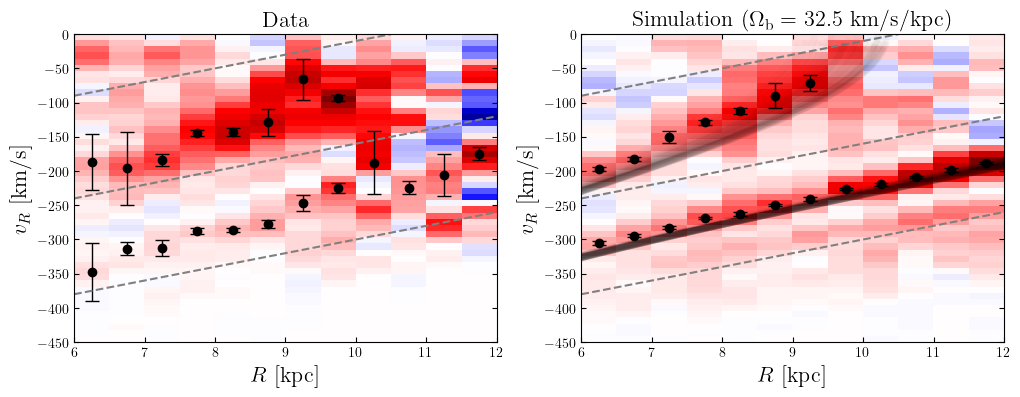

In [14]:
'''Generate data from antisymmetric distribution as function of radius'''
from scipy.signal import find_peaks, peak_widths
from scipy.ndimage import gaussian_filter
from scipy.stats import gaussian_kde

vR_bins = np.linspace(-450, 450, 101)
vR_grid = np.linspace(-450, 450, 1001)
vR_bincentres = (vR_bins[1:] + vR_bins[:-1])/2
vphi_bins = np.linspace(0, 100, 11)

vR_binwidth = vR_bins[1] - vR_bins[0]

R_bins = np.linspace(6, 12, 13)
R_bincentres = (R_bins[1:] + R_bins[:-1])/2


# Function to calculate R-vR antisymmetric histogram
def R_vR_antisym(R, vR, R_bins, vR_bins):
    hist, _, _ = np.histogram2d(R, vR, bins=(R_bins, vR_bins))

    hist = gaussian_filter(hist, (0,1))

    vR_bincentres = 0.5*(vR_bins[1:]+vR_bins[:-1])
    vphi_bincentres = 0.5*(vphi_bins[1:]+vphi_bins[:-1])

    hist_colnorm = hist / hist.sum(axis=1)[:,None]

    hist_antisym = (hist_colnorm - np.flip(hist_colnorm, axis=1))#/(hist + np.flip(hist, axis=1))#hist - np.flip(hist, axis=1)#0.5*(hist + np.flip(hist, axis=0))#/(hist + np.flip(hist, axis=0))
    hist_antisym = np.nan_to_num(hist_antisym)
    # hist_antisym_smooth = gaussian_filter(hist_antisym, (0,1))

    return hist_antisym

# Function to calculate kde in each vR bin
def R_vR_antisym_kde(R, vR, R_bins, vR_grid, sigma_kde):
    kde_antisym = np.zeros((len(R_bins)-1, len(vR_grid)))
    for i in range(len(R_bins)-1):
        cut = (R > R_bins[i])*(R < R_bins[i+1])
        bw = sigma_kde / np.std(vR[cut])
        kde = gaussian_kde(vR[cut], bw_method=bw)
        kde_grid = kde(vR_grid)
        kde_antisym[i] = (kde_grid - np.flip(kde_grid))#/(kde_grid + np.flip(kde_grid))
    
    # kde_antisym_smooth = gaussian_filter(kde_antisym, (1, 0))

    return kde_antisym

# Function to calculate peaks and uncertainties from bootstrapping
def calc_R_vR_peaks(R, vR, R_bins, vR_grid, sigma_kde, n_bootstrap, res_bounds):

    vR_gridspace = vR_grid[1] - vR_grid[0]

    # Array to store highest peaks
    # peaks_array = np.zeros((len(R_bins)-1, n_bootstrap, 4))

    CR_peaks = np.zeros((len(R_bins)-1, n_bootstrap))
    OLR_peaks = np.zeros((len(R_bins)-1, n_bootstrap))

    # Loop over all R bins
    for i in range(len(R_bins)-1):
        cut = (R > R_bins[i])*(R < R_bins[i+1])
        data = vR[cut]

        # Bootstrap sample
        for j in range(n_bootstrap):
            bootstrap_sample = np.random.choice(data, size=len(data), replace=True)
            # Fit kde and antisymmetrised kde
            bw = sigma_kde / np.std(bootstrap_sample)
            kde = gaussian_kde(bootstrap_sample, bw_method=bw)
            kde_grid = kde(vR_grid)
            kde_antisym = (kde_grid - np.flip(kde_grid))#/(kde_grid + np.flip(kde_grid))

            # Find peaks
            peak_indices, peak_props = find_peaks(kde_antisym, prominence=0., height=0.)#, distance=50/vR_gridspace)

            print(peak_indices)

            # Order peaks by their heights (or prominences)
            peak_prom = peak_props['prominences']
            peak_height = peak_props['peak_heights']
            peak_order = np.argsort(-peak_prom)

            # Select highest (or most prominent) peaks
            peak_indices = peak_indices[peak_order][:4]
            vR_peaks = vR_grid[peak_indices]

            # peaks_array[i,j,:len(vR_peaks)] = vR_peaks

            # Find peaks closest to boundary on either side, labelling them CR and OLR
            # Cut peaks above boundary
            peaks_inner = (vR_peaks < res_bounds[0](R_bincentres[i]))*(vR_peaks > res_bounds[1](R_bincentres[i]))*(vR_peaks < 0)
            peaks_outer = (vR_peaks < res_bounds[1](R_bincentres[i]))*(vR_peaks > res_bounds[2](R_bincentres[i]))*(vR_peaks < 0)

            _, _, left_ips, _ = peak_widths(kde_antisym, peak_indices, rel_height=0.5)
            
            try:
                CR_peaks[i,j] = vR_peaks[peaks_inner][0]
                # CR_peaks[i,j] = vR_grid[left_ips.astype(int)[peaks_inner][0]] #vR_peaks[peaks_inner][0]
            
            except:
                CR_peaks[i,j] = np.nan

            try:
                OLR_peaks[i,j] = vR_peaks[peaks_outer][0]
                # OLR_peaks[i,j] = vR_grid[left_ips.astype(int)[peaks_outer][0]] #vR_peaks[peaks_outer][0]

            except:
                OLR_peaks[i,j] = np.nan
    
    return CR_peaks, OLR_peaks




def calc_datapoints(peaks):
    y = np.nanmedian(peaks, axis=-1)
    yerr = 0.5*(np.nanpercentile(peaks, 84, axis=-1) - np.nanpercentile(peaks, 16, axis=-1))
    return y, yerr



# Calculate histograms or KDEs for data and sim
# Select range around the Sun
phi_range = 1/12*np.pi
z_max = 2

# And kde width (in km/s)
sigma_kde = 10
n_bootstrap = 100

# Boundary separating CR and OLR
res_bounds = [lambda R: 20*(R - 8) - 50, lambda R: 20*(R - 8) - 200, lambda R: 20*(R - 8) - 340]


# Data
cut_data = (Lz_data > 0)*(abs(Lz_data) < 500)*(abs(phi_data_sun) < phi_range)*(abs(z_data) < z_max)
hist_antisym_data = R_vR_antisym(R_data[cut_data], vR_data[cut_data], R_bins, vR_bins)

CR_peaks_data, OLR_peaks_data = calc_R_vR_peaks(R_data[cut_data], vR_data[cut_data], R_bins, vR_grid, sigma_kde, n_bootstrap, res_bounds)

x_CR_data = R_bincentres
x_OLR_data = R_bincentres

y_CR_data, yerr_CR_data = calc_datapoints(CR_peaks_data)
y_OLR_data, yerr_OLR_data = calc_datapoints(OLR_peaks_data)


# Cut data to limited radial range
N_bins_CR_data = 8

x_CR_data = x_CR_data[:N_bins_CR_data]
y_CR_data = y_CR_data[:N_bins_CR_data]
yerr_CR_data = yerr_CR_data[:N_bins_CR_data]

# Store datapoints in lists for fitting
x_list_data = [x_CR_data, x_OLR_data]
y_list_data = [y_CR_data, y_OLR_data]
yerr_list_data = [yerr_CR_data, yerr_OLR_data]


# Simulation
cut_sim = (Lz_sim[snap] > 0)*(abs(Lz_sim[snap]) < 500)*(abs(phi_sim_sun[snap]) < phi_range)*(abs(z_sim[snap]) < z_max)#(phi_sim[snap]%np.pi > 2/3*np.pi)*(phi_sim[snap] < np.pi)
hist_antisym_sim = R_vR_antisym(R_sim[snap,cut_sim], vR_sim[snap,cut_sim], R_bins, vR_bins)

CR_peaks_sim, OLR_peaks_sim = calc_R_vR_peaks(R_sim[snap,cut_sim], vR_sim[snap,cut_sim], R_bins, vR_grid, sigma_kde, n_bootstrap, res_bounds)

x_CR_sim = R_bincentres
x_OLR_sim = R_bincentres

y_CR_sim, yerr_CR_sim = calc_datapoints(CR_peaks_sim)
y_OLR_sim, yerr_OLR_sim = calc_datapoints(OLR_peaks_sim)

# Cut sim data to limited radial range
N_bins_CR_sim = 7

x_CR_sim = x_CR_sim[:N_bins_CR_sim]
y_CR_sim = y_CR_sim[:N_bins_CR_sim]
yerr_CR_sim = yerr_CR_sim[:N_bins_CR_sim]


# Plot antisymmetrised histograms
fig, axs = plt.subplots(1,2,figsize=(12,4))
axs[0].imshow(hist_antisym_data.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')
axs[1].imshow(hist_antisym_sim.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')

# Plot datapoints and errors
axs[0].errorbar(x_CR_data, y_CR_data, yerr_CR_data, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
axs[0].errorbar(x_OLR_data, y_OLR_data, yerr_OLR_data, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

axs[1].errorbar(x_CR_sim, y_CR_sim, yerr_CR_sim, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
axs[1].errorbar(x_OLR_sim, y_OLR_sim, yerr_OLR_sim, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

# Plot boundaries between resonant regions
for i in range(len(res_bounds)):
    axs[0].plot(R_bins, res_bounds[i](R_bins), ls='--', c='grey')
    axs[1].plot(R_bins, res_bounds[i](R_bins), ls='--', c='grey')

# # Plot peaks
# for i in range(len(R_bincentres)):
#     axs[0].scatter(R_bincentres[i]*np.ones(n_bootstrap), CR_peaks_data[i].flatten(), s=0.1, c='k')
#     axs[0].scatter(R_bincentres[i]*np.ones(n_bootstrap), OLR_peaks_data[i].flatten(), s=0.1, c='grey')

#     axs[1].scatter(R_bincentres[i]*np.ones(n_bootstrap), CR_peaks_sim[i].flatten(), s=0.1, c='k')
#     axs[1].scatter(R_bincentres[i]*np.ones(n_bootstrap), OLR_peaks_sim[i].flatten(), s=0.1, c='grey')
#     # axs[1].scatter(R_bincentres[i]*np.ones(), peaks_sim[i].flatten(), s=0.1, c='k')

# Calculate true resonant orbits for simulation
res_ratio_list = [0., 0.5]
Lz_grid = np.linspace(10, 500, 50)
R_grid = np.linspace(R_bins[0], R_bins[-1], 101)
 #make_pot(vcirc_sun_sim, a_NFW_sim, pot_axi_baryon)

for i in range(len(Lz_grid)):
    for j in range(len(res_ratio_list)):
        vR_res = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap], res_ratio_list[j], Lz_grid[i])
        axs[1].plot(R_grid, vR_res(R_grid), c='k', alpha=0.02, lw=5)


for ax in axs.flat:
    ax.set_ylim(top=0)
    ax.tick_params(top=True, bottom=True, right=True, left=True, direction='in')
    ax.set_xlabel('$R$ [kpc]', fontsize=16)
    ax.set_ylabel('$v_R$ [km/s]', fontsize=16)

axs[0].set_title('Data', fontsize=16)
axs[1].set_title('Simulation ($\Omega_\mathrm{b}=$ '+'{:.1f}'.format(Omega_b_sim[snap])+' km/s/kpc)', fontsize=16)


# # Calculate a fiducial OLR orbit
# pot_axi_Hunter = agama.Potential(agama_pot_path+'MWPotentialHunter24_axi.ini')
# vR_func_list = calc_res_orbit(pot_axi_Hunter, Omega_b_sim[snap], res_ratio_list, 250)

# for j in range(len(res_ratio_list)):
#     vR_func = vR_func_list[j]
#     R_grid = np.linspace(R_bins[0], R_bins[-1], 1001)
#     ax.plot(R_grid, vR_func(R_grid), c='k')

plt.show()
plt.close()




100%|██████████| 10000/10000 [00:02<00:00, 3402.68it/s]


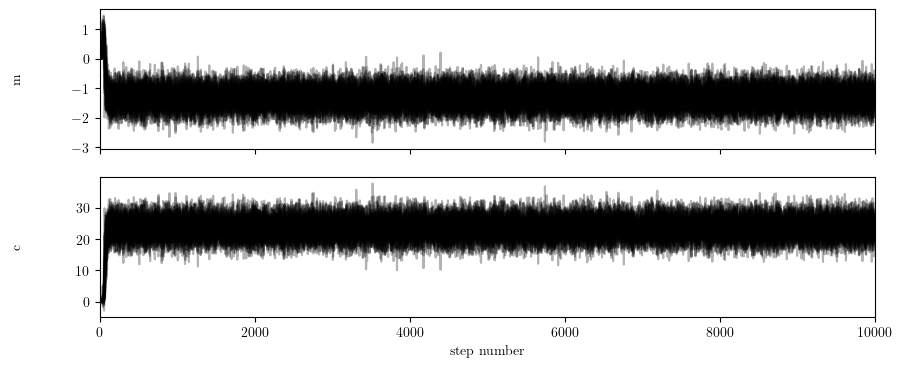

Covariance matrix: [[ 0.10660384 -0.96979056]
 [-0.96979056  9.10505694]]
Prior for m: -1.3272862430586283 ± 0.3264939315244908
Prior for c: 23.531500172762122 ± 3.0173801082607596


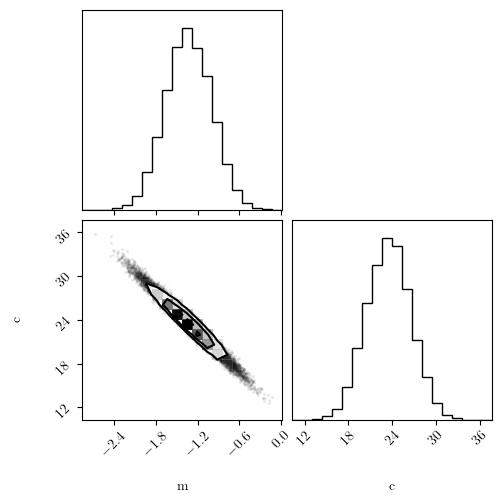

In [41]:
'''Calculate priors on offsets between resonances and peaks based on simulation'''

import emcee, corner

# Calculate true resonant orbits
res_ratio = 0.5
vR_res = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap], res_ratio, 250, 0, 0)

# Calculate differences from data points
y_OLR_sim_diff = y_OLR_sim - vR_res(x_OLR_sim)


# Define the likelihood function
def log_likelihood_adjust(theta, x, y, sigma_y):
    m, c = theta
    model = m * x + c
    return -0.5 * np.sum(((y - model) / sigma_y)**2 + np.log(2 * np.pi * sigma_y**2))

# Define priors
def log_prior_adjust(theta):
    m, c = theta
    if -20 < m < 20 and -200 < c < 200:  # Uniform priors
        return 0.0
    return -np.inf

# Define posterior
def log_probability_adjust(theta, x, y, sigma_y):
    lp = log_prior_adjust(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood_adjust(theta, x, y, sigma_y)


# Initialize walkers
nwalkers, ndim = 32, 2
pos = [0, 0] + 1e-4 * np.random.randn(nwalkers, ndim)

# Run MCMC
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_adjust, args=(x_OLR_sim, y_OLR_sim_diff, yerr_OLR_sim))
sampler.run_mcmc(pos, 10000, progress=True)

fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ['m', 'c']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

plt.show()
plt.close()


# Analyze the results
samples = sampler.get_chain(discard=1000, thin=15, flat=True)

fig = corner.corner(
    samples, labels=labels
)


# Calculate means and covariance matrix
m_mean = np.mean(samples[:,0])
c_mean = np.mean(samples[:,1])
m_c_cov = np.cov(samples.T)

print('Covariance matrix:', m_c_cov)

m_std = np.std(samples[:,0])
c_std = np.std(samples[:,1])

print('Prior for m:', m_mean, '±', m_std)
print('Prior for c:', c_mean, '±', c_std)


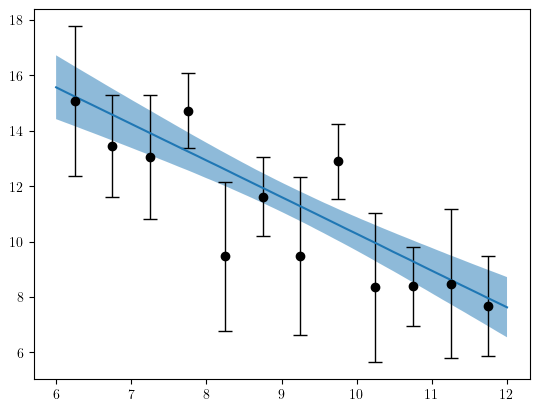

In [36]:
# Plot simulation peaks with uncertainties
# plt.errorbar(x_CR_sim, y_CR_sim, yerr_CR_sim, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
plt.errorbar(x_OLR_sim, y_OLR_sim_diff, yerr_OLR_sim, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

# Plot true resonant orbits
R_grid = np.linspace(R_bins[0], R_bins[-1], 100)
# plt.plot(R_grid, vR_res(R_grid))

fits = samples[:,0][None,:] * R_grid[:,None] + samples[:,1][None,:]

plt.plot(R_grid, np.median(fits, axis=1))
plt.fill_between(R_grid, np.percentile(fits, 16, axis=1), np.percentile(fits, 84, axis=1), alpha=0.5)




In [ ]:
'''Define functions to calculate log prior and log probability'''

vcirc_sun_mean = 229 #236.9
vcirc_sun_std = 6 #4.2

M20_mean = 1.91
M20_std = 0.18

# Log prior
def calc_log_prior(theta):
    vcirc_sun, M20, Omega_b, Lz, m, c, sigma_model = theta

    # Prior is uniform in pattern speed and NFW scale radius, and Gaussian in circular speed and energy offsets
    if (20 < Omega_b < 50) & (0 < M20) & (0 < Lz < 500) & (vcirc_sun > 0) & (0 < sigma_model < 100):
        inv_m_c_cov = np.linalg.inv(m_c_cov)
        diff_m_c = np.array([m, c]) - np.array([m_mean, c_mean])
        return -0.5 * ((vcirc_sun - vcirc_sun_mean)**2 / vcirc_sun_std**2 + (M20 - M20_mean)**2 / M20_std**2 + diff_m_c.T @ inv_m_c_cov @ diff_m_c)
    
    else:
        return -np.inf

def calc_log_probability(theta, x, y, yerr, pot_axi_baryon, res_ratio):
    lp = calc_log_prior(theta)
    
    if not np.isfinite(lp):
        return -np.inf
    return lp + calc_log_likelihood(theta, x, y, yerr, pot_axi_baryon, res_ratio)

In [43]:
'''Find maximum likelihood or posterior'''
from scipy.optimize import minimize

nlp = lambda *args: -calc_log_probability(*args)

initial = [230, 2, 35, 250, 0, 0, 10]
# initial = [235, 19.6, 35, 250, E_offset_mean, 10]

# Select data or simulation to fit
x = x_OLR_sim #x_OLR_sim
y = y_OLR_sim#sim
yerr = yerr_OLR_sim#sim
res_ratio = 0.5

soln = minimize(nlp, initial, args=(x, y, yerr, pot_axi_baryon, res_ratio), method='Nelder-Mead')

Maximum likelihood parameters: [ 2.18945638e+02  1.89975719e+00  3.26788721e+01  3.34234944e+02
  3.56529429e-03 -6.80777699e-04  7.93462564e-06]


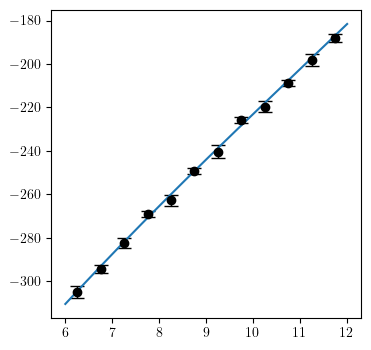

In [44]:
'''Plot data and maximum likelihood model'''

fig, ax = plt.subplots(1, figsize=(4,4))

# '''Maximum likelihood model'''
# max_likelihood_index = np.unravel_index(log_likelihood_array.argmax(), log_likelihood_array.shape)

# print(np.max(log_likelihood_array))

theta_max = soln.x#[vcirc_sun, a_NFW_grid[max_likelihood_index[1]], Omega_b_grid[max_likelihood_index[0]]]
print('Maximum likelihood parameters:', theta_max)

R_grid = np.linspace(R_bins[0], R_bins[-1], 1001)

vR_func = calc_model_func(theta_max, pot_axi_baryon, res_ratio)

ax.errorbar(x, y, yerr, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)
ax.plot(R_grid, vR_func(R_grid))


In [45]:
'''Run MCMC'''

import emcee

# theta_true = [vcirc_sun_sim, a_NFW_sim, Omega_b_sim[snap], E_offset_mean]
pos = soln.x + 1e-4 * np.random.randn(32, len(soln.x))
nwalkers, ndim = pos.shape

sampler = emcee.EnsembleSampler(
    nwalkers, ndim, calc_log_probability, args=(x, y, yerr, pot_axi_baryon, res_ratio)
)
sampler.run_mcmc(pos, 1000, progress=True)

  0%|          | 0/1000 [00:00<?, ?it/s]/opt/anaconda3/envs/myenv/lib/python3.12/site-packages/emcee/moves/red_blue.py:99: RuntimeWarning: invalid value encountered in scalar subtract
  lnpdiff = f + nlp - state.log_prob[j]
 10%|█         | 104/1000 [00:37<05:58,  2.50it/s]/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/2578349095.py:16: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a_NFW = fsolve(mass_ratio_diff, x0=initial_guess, args=(M_inner, M_outer, r_inner, r_outer))[0]
 24%|██▍       | 240/1000 [01:28<04:47,  2.64it/s]/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/2578349095.py:9: RuntimeWarning: invalid value encountered in log
  return (np.log(1 + r_outer/a_NFW) - r_outer/(a_NFW + r_outer)) / (np.log(1 + r_inner/a_NFW) - r_inner/(a_NFW + r_inner))
100%|██████████| 1000/1000 [06:18<00:00,  2.64it/s]


State([[ 2.28563599e+02  2.06660683e+00  3.32733650e+01  1.01160709e+02
  -1.77624516e+00  2.74434435e+01  4.02574639e-01]
 [ 2.31768679e+02  1.74355308e+00  3.17395902e+01  3.03061327e+02
  -1.26633774e+00  2.26948762e+01  7.35149695e-01]
 [ 2.26140201e+02  1.89252020e+00  3.15963749e+01  1.12159300e+02
  -1.24611149e+00  2.25045846e+01  3.11042443e-01]
 [ 2.27133909e+02  2.06393059e+00  3.33921767e+01  2.43042678e+02
  -6.89310831e-01  1.80376096e+01  2.49889161e-01]
 [ 2.29392784e+02  2.08143581e+00  3.34010208e+01  6.88055062e+01
  -1.69456950e+00  2.72168038e+01  3.54568408e-01]
 [ 2.28883527e+02  2.00030389e+00  3.29450718e+01  1.01505420e+02
  -1.34688171e+00  2.34133382e+01  4.96668050e-02]
 [ 2.27711591e+02  1.85610151e+00  3.12727896e+01  8.97576431e+01
  -1.55286404e+00  2.61142236e+01  4.89758764e-01]
 [ 2.32894030e+02  1.84678643e+00  3.26449418e+01  4.62174704e+02
  -1.44113631e+00  2.45903172e+01  9.61120732e-01]
 [ 2.30470510e+02  2.06387165e+00  3.37551003e+01  1.69332

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\,'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\,'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\s'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/3945905967.py:5: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$v_\mathrm{circ}$ [km/s]', '$M(<20\,\mathrm{kpc})$ [$10^{11}M_\odot$]', '$\Omega_\mathrm{b}$ [km/s/kpc]', '$L_z$ [kpc km/s]', 'm', 'c', '$\sigma_\mathrm{model}$ [km/s]']
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/3945905967.py:5: SyntaxWarning: invalid escape sequence '\,'
  labels = ['$v_\mathrm{circ}$ [km/s]', '$M(<20\,\mathrm{kpc})$ [$10^{11}M_\odot$]', '$\Omega_\mathrm{b}$ [km/s/kpc]', '$L_z$ [kpc km/s]', 'm', 'c', '$\sigma_\mathrm

Text(0.5, 0, 'step number')

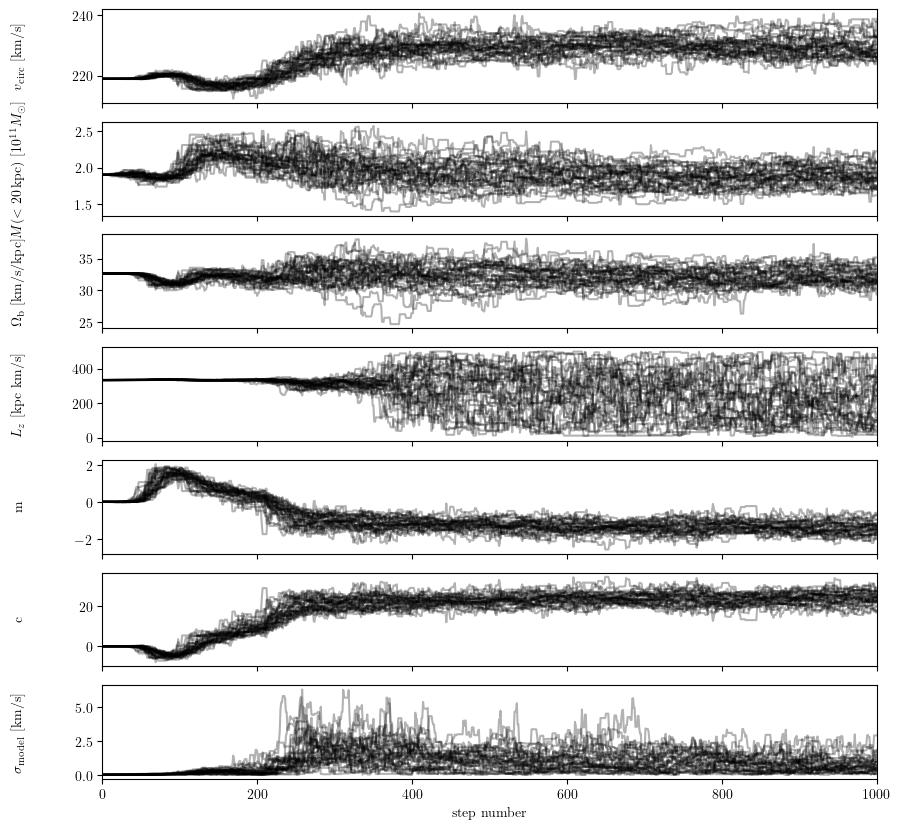

In [46]:
'''Display MCMC chains'''

fig, axes = plt.subplots(7, figsize=(10, 10), sharex=True)
samples = sampler.get_chain()
labels = ['$v_\mathrm{circ}$ [km/s]', '$M(<20\,\mathrm{kpc})$ [$10^{11}M_\odot$]', '$\Omega_\mathrm{b}$ [km/s/kpc]', '$L_z$ [kpc km/s]', 'm', 'c', '$\sigma_\mathrm{model}$ [km/s]']
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number")

In [47]:
tau = sampler.get_autocorr_time()
print(tau)

AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [120.36352134  74.90132165  59.17381615  88.02220451 121.30422783
 123.44497587  60.48313176]

<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\s'
<>:11: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\,'
<>:11: SyntaxWarning: invalid escape sequence '\O'
<>:11: SyntaxWarning: invalid escape sequence '\s'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/368203374.py:11: SyntaxWarning: invalid escape sequence '\m'
  labels = ['$v_\mathrm{circ}$ [km/s]', '$M(<20\,\mathrm{kpc})$ [$10^{11}M_\odot$]', '$\Omega_\mathrm{b}$ [km/s/kpc]', '$L_z$ [kpc km/s]', '$m$ [km/s/kpc]', '$c$ [km/s]', '$\sigma_\mathrm{model}$ [km/s]']
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_89365/368203374.py:11: SyntaxWarning: invalid escape sequence '\,'
  labels = ['$v_\mathrm{circ}$ [km/s]', '$M(<20\,\mathrm{kpc})$ [$10^{11}M_\odot$]', '$\Omega_\mathrm{b}$ [km/s/kpc]', '$L_z$ [kpc km/s

[228.82908871423456, 1.9332801965472497, 32.50270916353844, 250, -1, 20, 0]


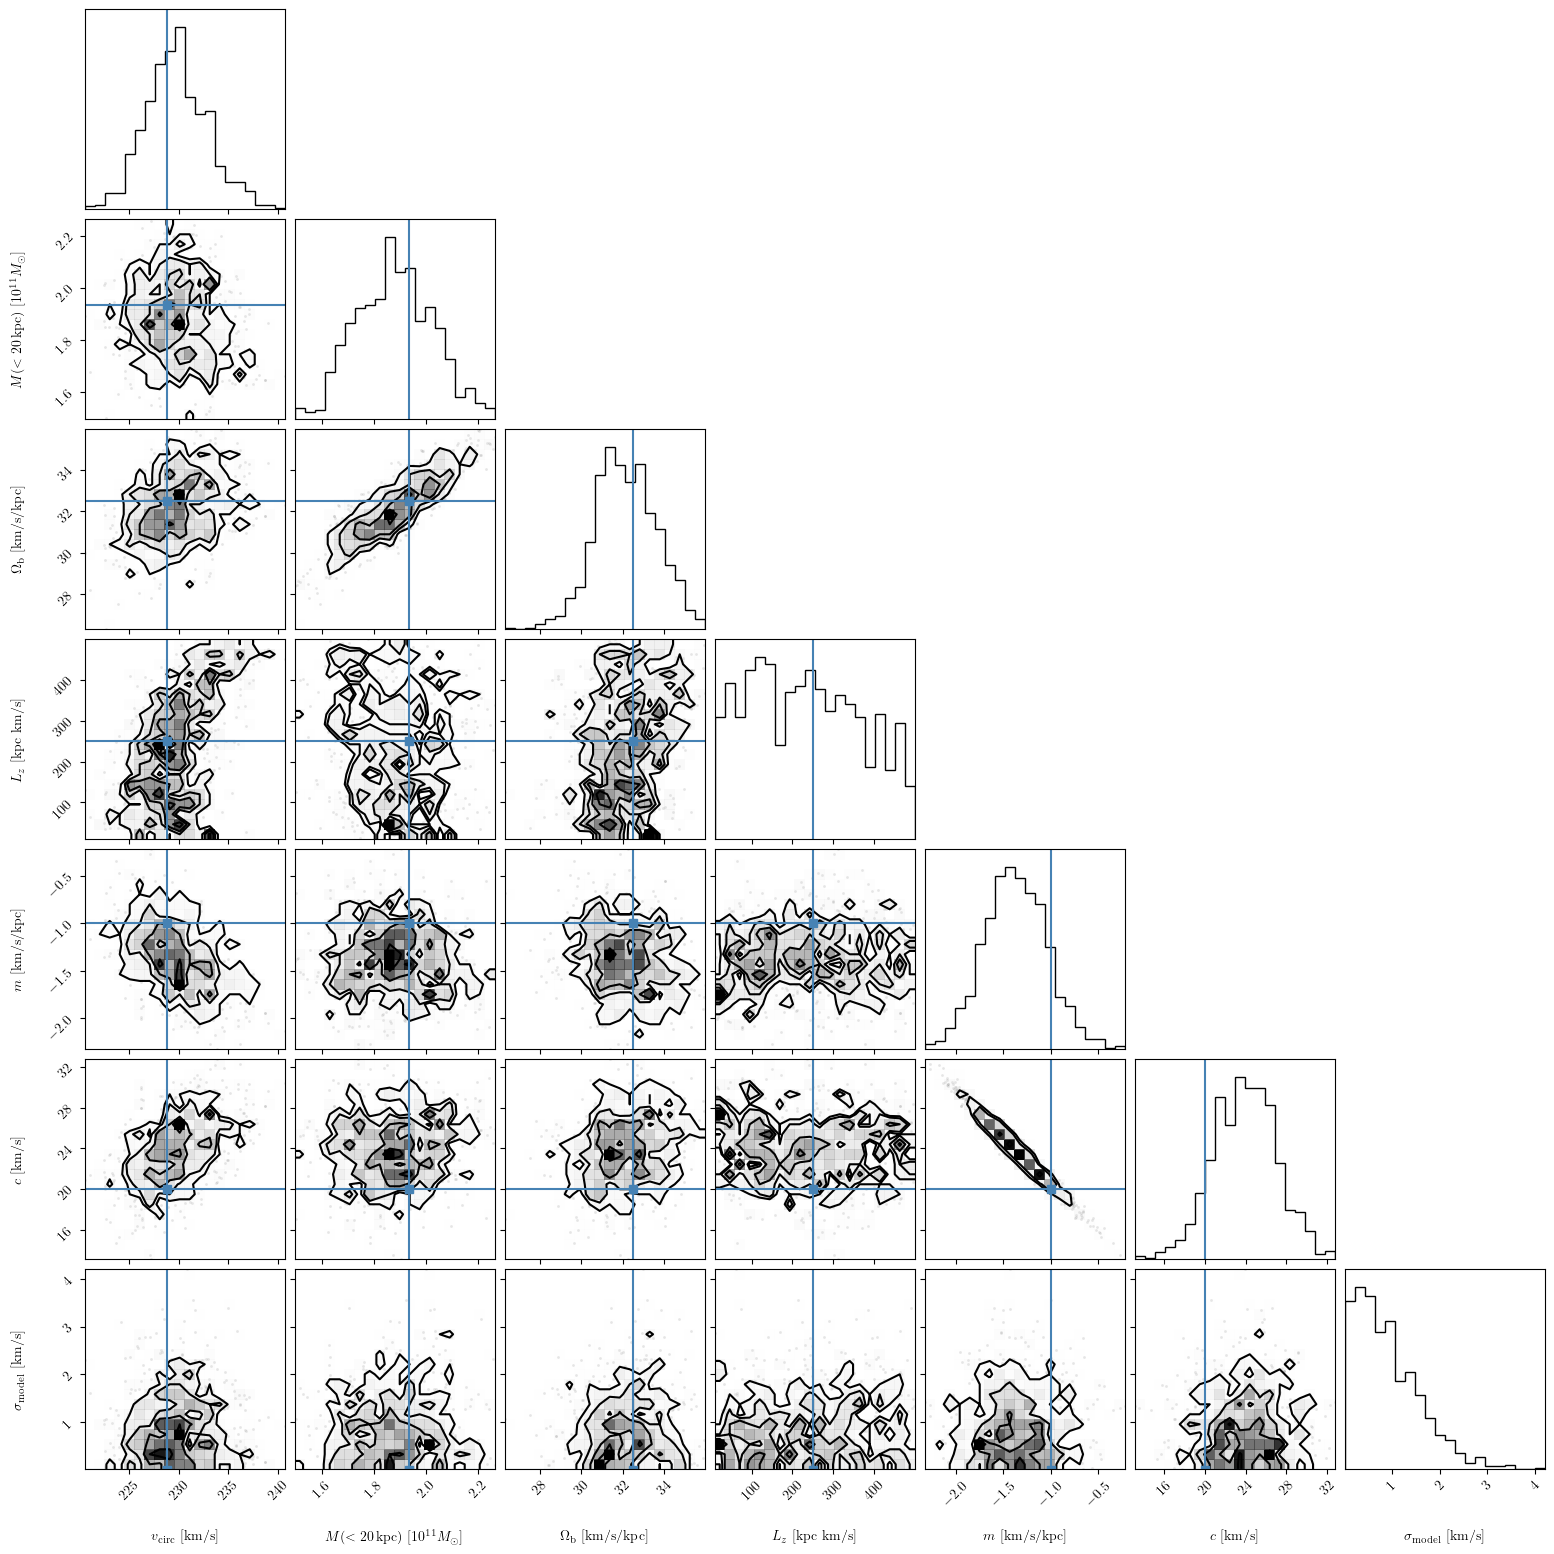

In [48]:
'''Display corner plot'''

import corner

flat_samples = sampler.get_chain(discard=600, thin=15, flat=True)

theta_true = [vcirc_sun_sim, M20_sim, Omega_b_sim[snap], 250, -1, 20, 0]

print(theta_true)

labels = ['$v_\mathrm{circ}$ [km/s]', '$M(<20\,\mathrm{kpc})$ [$10^{11}M_\odot$]', '$\Omega_\mathrm{b}$ [km/s/kpc]', '$L_z$ [kpc km/s]', '$m$ [km/s/kpc]', '$c$ [km/s]', '$\sigma_\mathrm{model}$ [km/s]']

fig = corner.corner(
    flat_samples, labels=labels, truths=theta_true
)

In [136]:
'''Display parameter posteriors and confidence intervals'''

from IPython.display import display, Math

labels = ['v_\mathrm{circ}', 'M(<20)', '\Omega_\mathrm{b}', 'L_z', 'm', 'c', '\sigma_\mathrm{model}']
units = ['\mathrm{km/s}', '10^{11}M_\odot', '\mathrm{km/s/kpc}', '\mathrm{kpc\,km/s}', '\mathrm{km/s/kpc}', '\mathrm{km/s}', '\mathrm{km/s}']

for i in range(ndim):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    txt = "{{{3}}} = {0:.4}_{{-{1:.4}}}^{{+{2:.4}}}\:{{{4}}}"
    txt = txt.format(mcmc[1], q[0], q[1], labels[i], units[i])
    display(Math(txt))



<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:11: SyntaxWarning: invalid escape sequence '\:'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\O'
<>:5: SyntaxWarning: invalid escape sequence '\s'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\o'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'
<>:6: SyntaxWarning: invalid escape sequence '\m'

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<>:95: SyntaxWarning: invalid escape sequence '\o'
<>:97: SyntaxWarning: invalid escape sequence '\m'
<>:95: SyntaxWarning: invalid escape sequence '\o'
<>:97: SyntaxWarning: invalid escape sequence '\m'
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_84177/856047415.py:95: SyntaxWarning: invalid escape sequence '\o'
  axs[1].set_ylabel('$M(<r)$ [$10^{11} M_\odot$]', fontsize=16)
/var/folders/z0/1zblnsv52b3_xm5q_770smk40000gn/T/ipykernel_84177/856047415.py:97: SyntaxWarning: invalid escape sequence '\m'
  axs[2].set_ylabel('$v_\mathrm{circ}(r)$ [km/s]', fontsize=16)


Text(0, 0.5, '$v_\\mathrm{circ}(r)$ [km/s]')

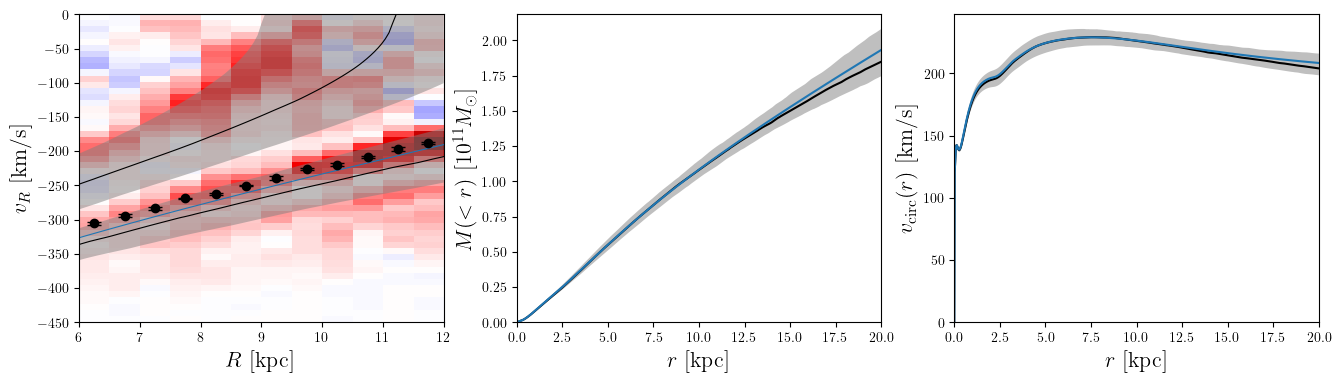

In [137]:
'''Plot best-fitting models'''

# Grids for plotting radial phase space and mass enclosed
R_grid = np.linspace(6, 12, 101)
r_grid = np.linspace(0, 20, 1001)

res_ratio = 0.5

fig, axs = plt.subplots(1, 3, figsize=(16,4))

N_samples = 200
Menc_array = np.zeros((N_samples, len(r_grid)))
vcirc_array = np.zeros((N_samples, len(r_grid)))
vR_res_array = np.zeros((N_samples, len(R_grid)))
vR_res_CR_array = np.zeros((N_samples, len(R_grid)))

for i in range(N_samples):
    # print(flat_samples[i,0])
    pot_mod = make_pot(flat_samples[i,0], flat_samples[i,1], pot_axi_baryon)

    vR_res = calc_res_orbit(pot_mod, flat_samples[i,2], res_ratio, flat_samples[i,3], 0, 0)#flat_samples[i,4], flat_samples[i,5])
    vR_res_CR = calc_res_orbit(pot_mod, flat_samples[i,2], 0, 250, 0, 0)

    vR_res_array[i] = np.nan_to_num(vR_res(R_grid))
    vR_res_CR_array[i] = np.nan_to_num(vR_res_CR(R_grid))

    Menc = pot_mod.enclosedMass(r_grid)/1e11
    Menc_array[i] = Menc

    vcirc = (-r_grid * pot_mod.force(np.array([r_grid, 0*r_grid, 0*r_grid]).T)[:,0])**0.5
    vcirc_array[i] = vcirc

vR_res_sim = calc_res_orbit(pot_axi_sim, Omega_b_sim[snap], res_ratio, 250, 0, 0)(R_grid)
Menc_sim = pot_axi_sim.enclosedMass(r_grid)/1e11
vcirc_sim = (-r_grid * pot_axi_sim.force(np.array([r_grid, 0*r_grid, 0*r_grid]).T)[:,0])**0.5


# Plot radial phase space
axs[0].imshow(hist_antisym_sim.T, extent=(R_bins[0], R_bins[-1], vR_bins[0], vR_bins[-1]), cmap='seismic', origin='lower', interpolation='none', aspect='auto')
axs[0].errorbar(x, y, yerr, c='k', fmt='o', capsize=5, elinewidth=1, capthick=1)

axs[0].plot(R_grid, np.nanmedian(vR_res_array, axis=0), c='k', lw=0.8)
axs[0].fill_between(R_grid, np.nanpercentile(vR_res_array, 16, axis=0), np.nanpercentile(vR_res_array, 84, axis=0), fc='grey', alpha=0.5)
axs[0].plot(R_grid, vR_res_sim, c='tab:blue', lw=0.8)

# axs[0].plot(R_grid, np.nanpercentile(vR_res_array, 16, axis=0), c='k', ls='--', lw=0.8)
# axs[0].plot(R_grid, np.nanpercentile(vR_res_array, 84, axis=0), c='k', ls='--', lw=0.8)

axs[0].plot(R_grid, np.nanmedian(vR_res_CR_array, axis=0), c='k', lw=0.8)
axs[0].fill_between(R_grid, np.nanpercentile(vR_res_CR_array, 16, axis=0), np.nanpercentile(vR_res_CR_array, 84, axis=0), fc='grey', alpha=0.5)


# axs[0].plot(R_grid, np.nanpercentile(vR_res_CR_array, 16, axis=0), c='k', ls='--', lw=0.8)
# axs[0].plot(R_grid, np.nanpercentile(vR_res_CR_array, 84, axis=0), c='k', ls='--', lw=0.8)

axs[1].plot(r_grid, np.nanmedian(Menc_array, axis=0), c='k')
axs[1].fill_between(r_grid, np.nanpercentile(Menc_array, 16, axis=0), np.nanpercentile(Menc_array, 84, axis=0), fc='grey', alpha=0.5)
axs[1].plot(r_grid, Menc_sim, c='tab:blue')

axs[2].plot(r_grid, np.nanmedian(vcirc_array, axis=0), c='k')
axs[2].fill_between(r_grid, np.nanpercentile(vcirc_array, 16, axis=0), np.nanpercentile(vcirc_array, 84, axis=0), fc='grey', alpha=0.5)
axs[2].plot(r_grid, vcirc_sim, c='tab:blue')

# axs[1].plot(r_grid, np.nanpercentile(Menc_array, 16, axis=0), c='k', ls='--')
# axs[1].plot(r_grid, np.nanpercentile(Menc_array, 84, axis=0), c='k', ls='--')




# pot_mod = make_pot(vcirc_sun_sim, M20_sim, pot_axi_baryon)

# vR_res_true = calc_res_orbit(pot_mod, Omega_b_sim[snap], res_ratio_list, 250, Delta_E_OLR_mean)

# plt.plot(R_grid, vR_res_true(R_grid))


# plt.plot(R_grid, np.median(vR_res_array), c='k')
# plt.plot(R_grid, np.percentile(vR_res_array, 16), c='k', ls='--')
# plt.plot(R_grid, np.percentile(vR_res_array, 84), c='k', ls='--')


    # plt.plot(R_grid, vR_res[1](R_grid), alpha=0.1, c='k')


axs[0].set_ylim(vR_bins[0],0)
axs[1].set_xlim(0,20)
axs[1].set_ylim(0)
axs[2].set_xlim(0,20)
axs[2].set_ylim(0)

axs[0].set_xlabel('$R$ [kpc]', fontsize=16)
axs[0].set_ylabel('$v_R$ [km/s]', fontsize=16)

axs[1].set_xlabel('$r$ [kpc]', fontsize=16)
axs[1].set_ylabel('$M(<r)$ [$10^{11} M_\odot$]', fontsize=16)
axs[2].set_xlabel('$r$ [kpc]', fontsize=16)
axs[2].set_ylabel('$v_\mathrm{circ}(r)$ [km/s]', fontsize=16)


# print(calc_log_probability(np.median(flat_samples, axis=0), x, y, yerr, pot_axi_baryon, res_ratio))


# theta_true = [vcirc_sun_sim, M20_sim, Omega_b_sim[snap], 250, Delta_E_OLR_mean, 0]

# print(calc_log_probability(theta_true, x, y, yerr, pot_axi_baryon, res_ratio))


